In [60]:
#Packages to install
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import pooch
import os
import h5py
import igraph
import leidenalg
import seaborn as sns # not needed

print("packages are installed correctly.")


packages are installed correctly.


In [61]:
# Read data files
Ctrl1 = sc.read_10x_h5("/Users/25advaym/genomics/GLPvsSAL/Ctrl1/Ctrl1.h5")
Ctrl2 = sc.read_10x_h5("/Users/25advaym/genomics/GLPvsSAL/Ctrl2/Ctrl2.h5")
Obese1 = sc.read_10x_h5("/Users/25advaym/genomics/GLPvsSAL/Obese1/Obese1.h5")
Obese2 = sc.read_10x_h5("/Users/25advaym/genomics/GLPvsSAL/Obese2/Obese2.h5")


# Make variable names unique across datasets
for data in [Ctrl1, Ctrl2, Obese1, Obese2]:
    data.var_names_make_unique()
    data.obs_names_make_unique()


/Users/25advaym/miniconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/25advaym/miniconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/25advaym/miniconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/25advaym/miniconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/25advaym/miniconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are n

/Users/25advaym/miniconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 15492 × 33696
    obs: 'sample'


/Users/25advaym/miniconda3/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


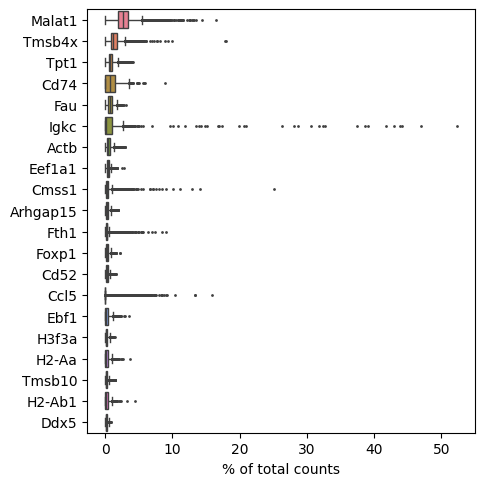

In [62]:


# Concatenate the datasets
merged = ad.concat(
    [Ctrl1, Ctrl2, Obese1, Obese2],
    label='sample',  # New column name for sample origin
    keys=['Ctrl1', 'Ctrl2', 'Obese1', 'Obese2'],  # Values for the sample column
    join='outer',  # Join type (union of genes)
    index_unique=None  # Keep original index if possible
)

merged.var_names_make_unique()
merged.obs_names_make_unique()

# Check the merged data
print(merged)

sc.pp.filter_cells(merged, min_genes=200)
sc.pp.filter_genes(merged, min_cells=3)

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
merged.var["mt"] = merged.var_names.str.startswith("mt")
# ribosomal genes
merged.var["ribo"] = merged.var_names.str.startswith(("Rps", "Rpl"))

# Create a combined mask for mitochondrial and ribosomal genes
exclude_genes_mask = merged.var["mt"] | merged.var["ribo"]

# Reassign merged to exclude these genes
merged = merged[:, ~exclude_genes_mask]



sig_genes = sc.pl.highest_expr_genes(merged, n_top=20)

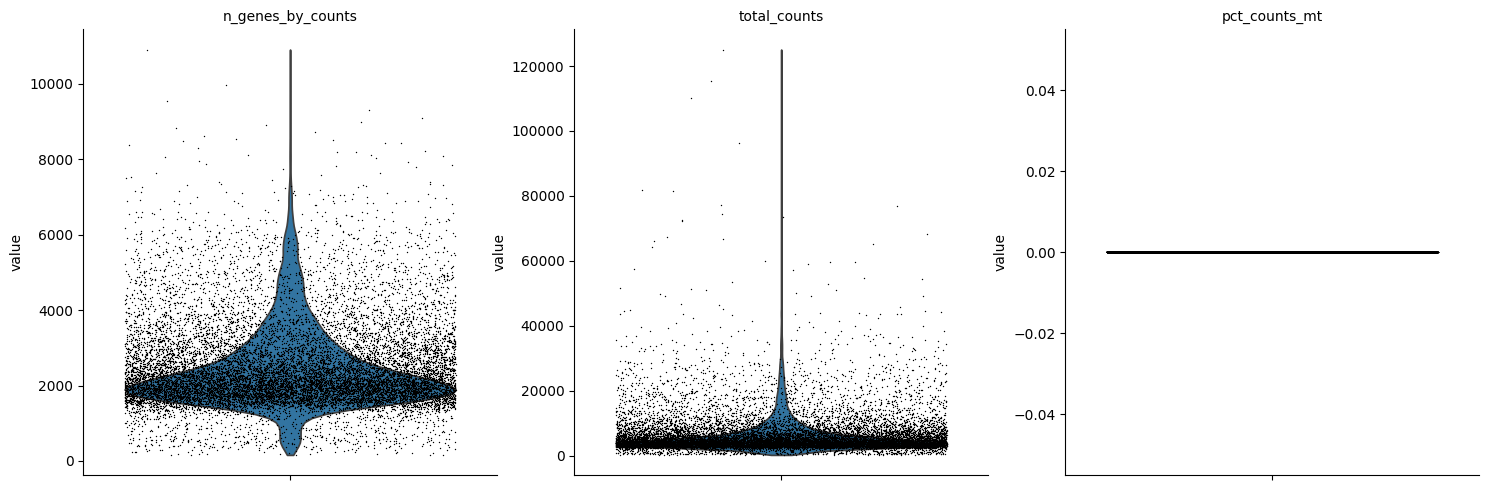

In [63]:
# Quality control
sc.pp.calculate_qc_metrics(
    merged, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)

# Violin Plot of data
sc.pl.violin(
    merged,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

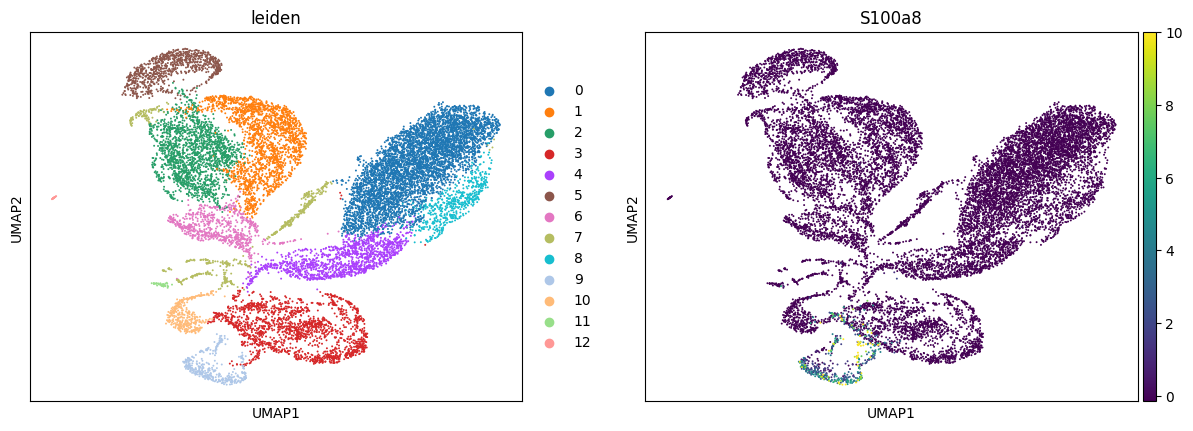

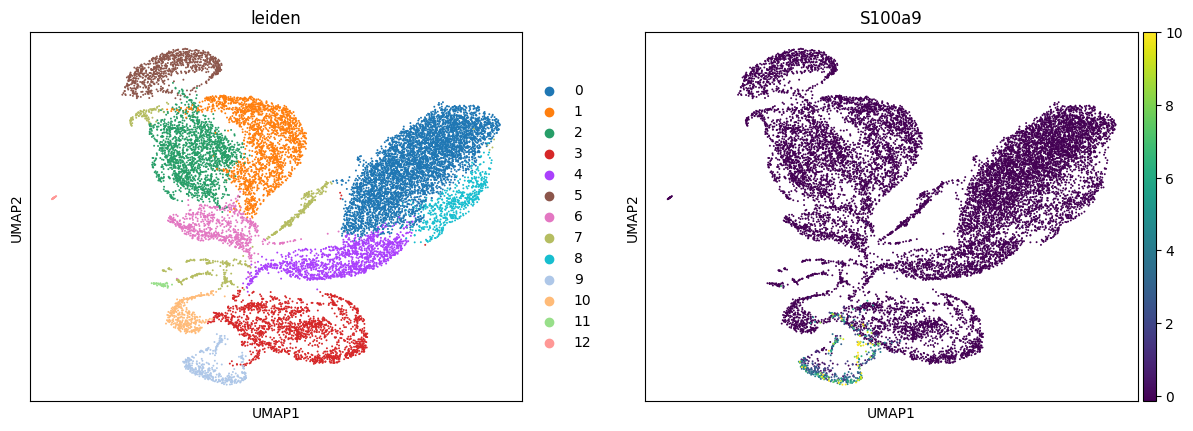

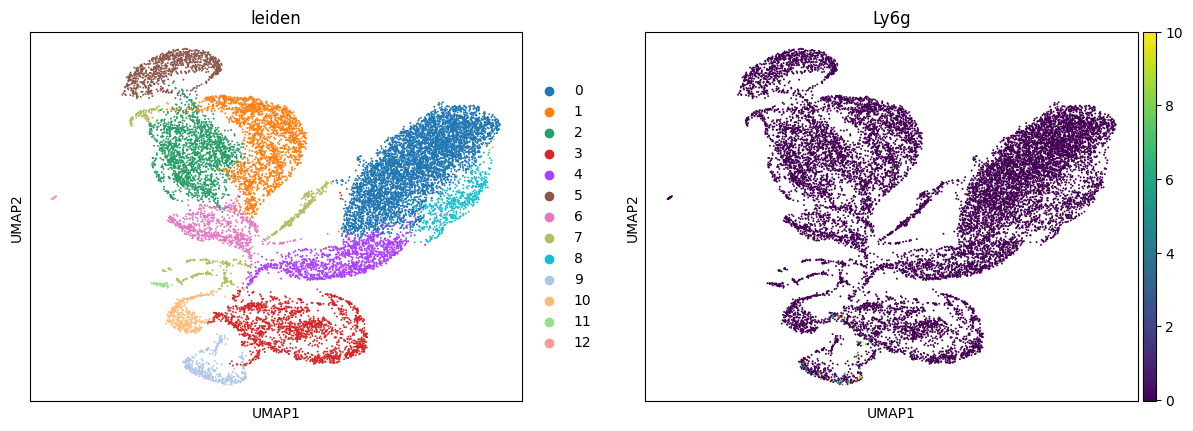

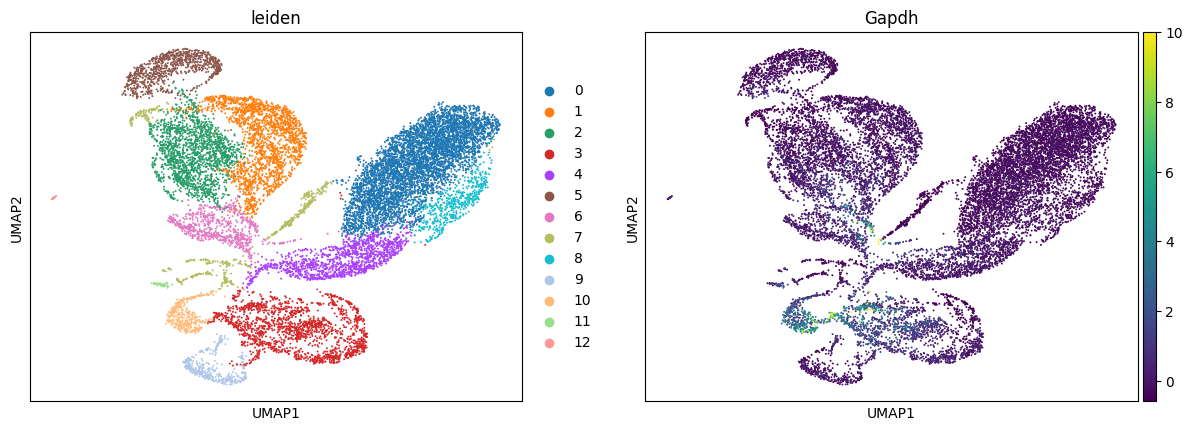

In [64]:
# Clustering and UMAP
sc.pp.scale(merged, max_value=10)
sc.tl.pca(merged, svd_solver='arpack')
sc.pp.neighbors(merged, n_neighbors=10, n_pcs=40)
sc.tl.umap(merged)
sc.tl.leiden(merged, resolution=0.2)


# Feature Plots
sc.pl.umap(merged, color=['leiden', 'S100a8'])
sc.pl.umap(merged, color=['leiden', 'S100a9'])
sc.pl.umap(merged, color=['leiden', 'Ly6g'])
sc.pl.umap(merged, color=['leiden', 'Gapdh'])



/Users/25advaym/miniconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/25advaym/miniconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/25advaym/miniconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/25advaym/miniconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/25advaym/miniconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


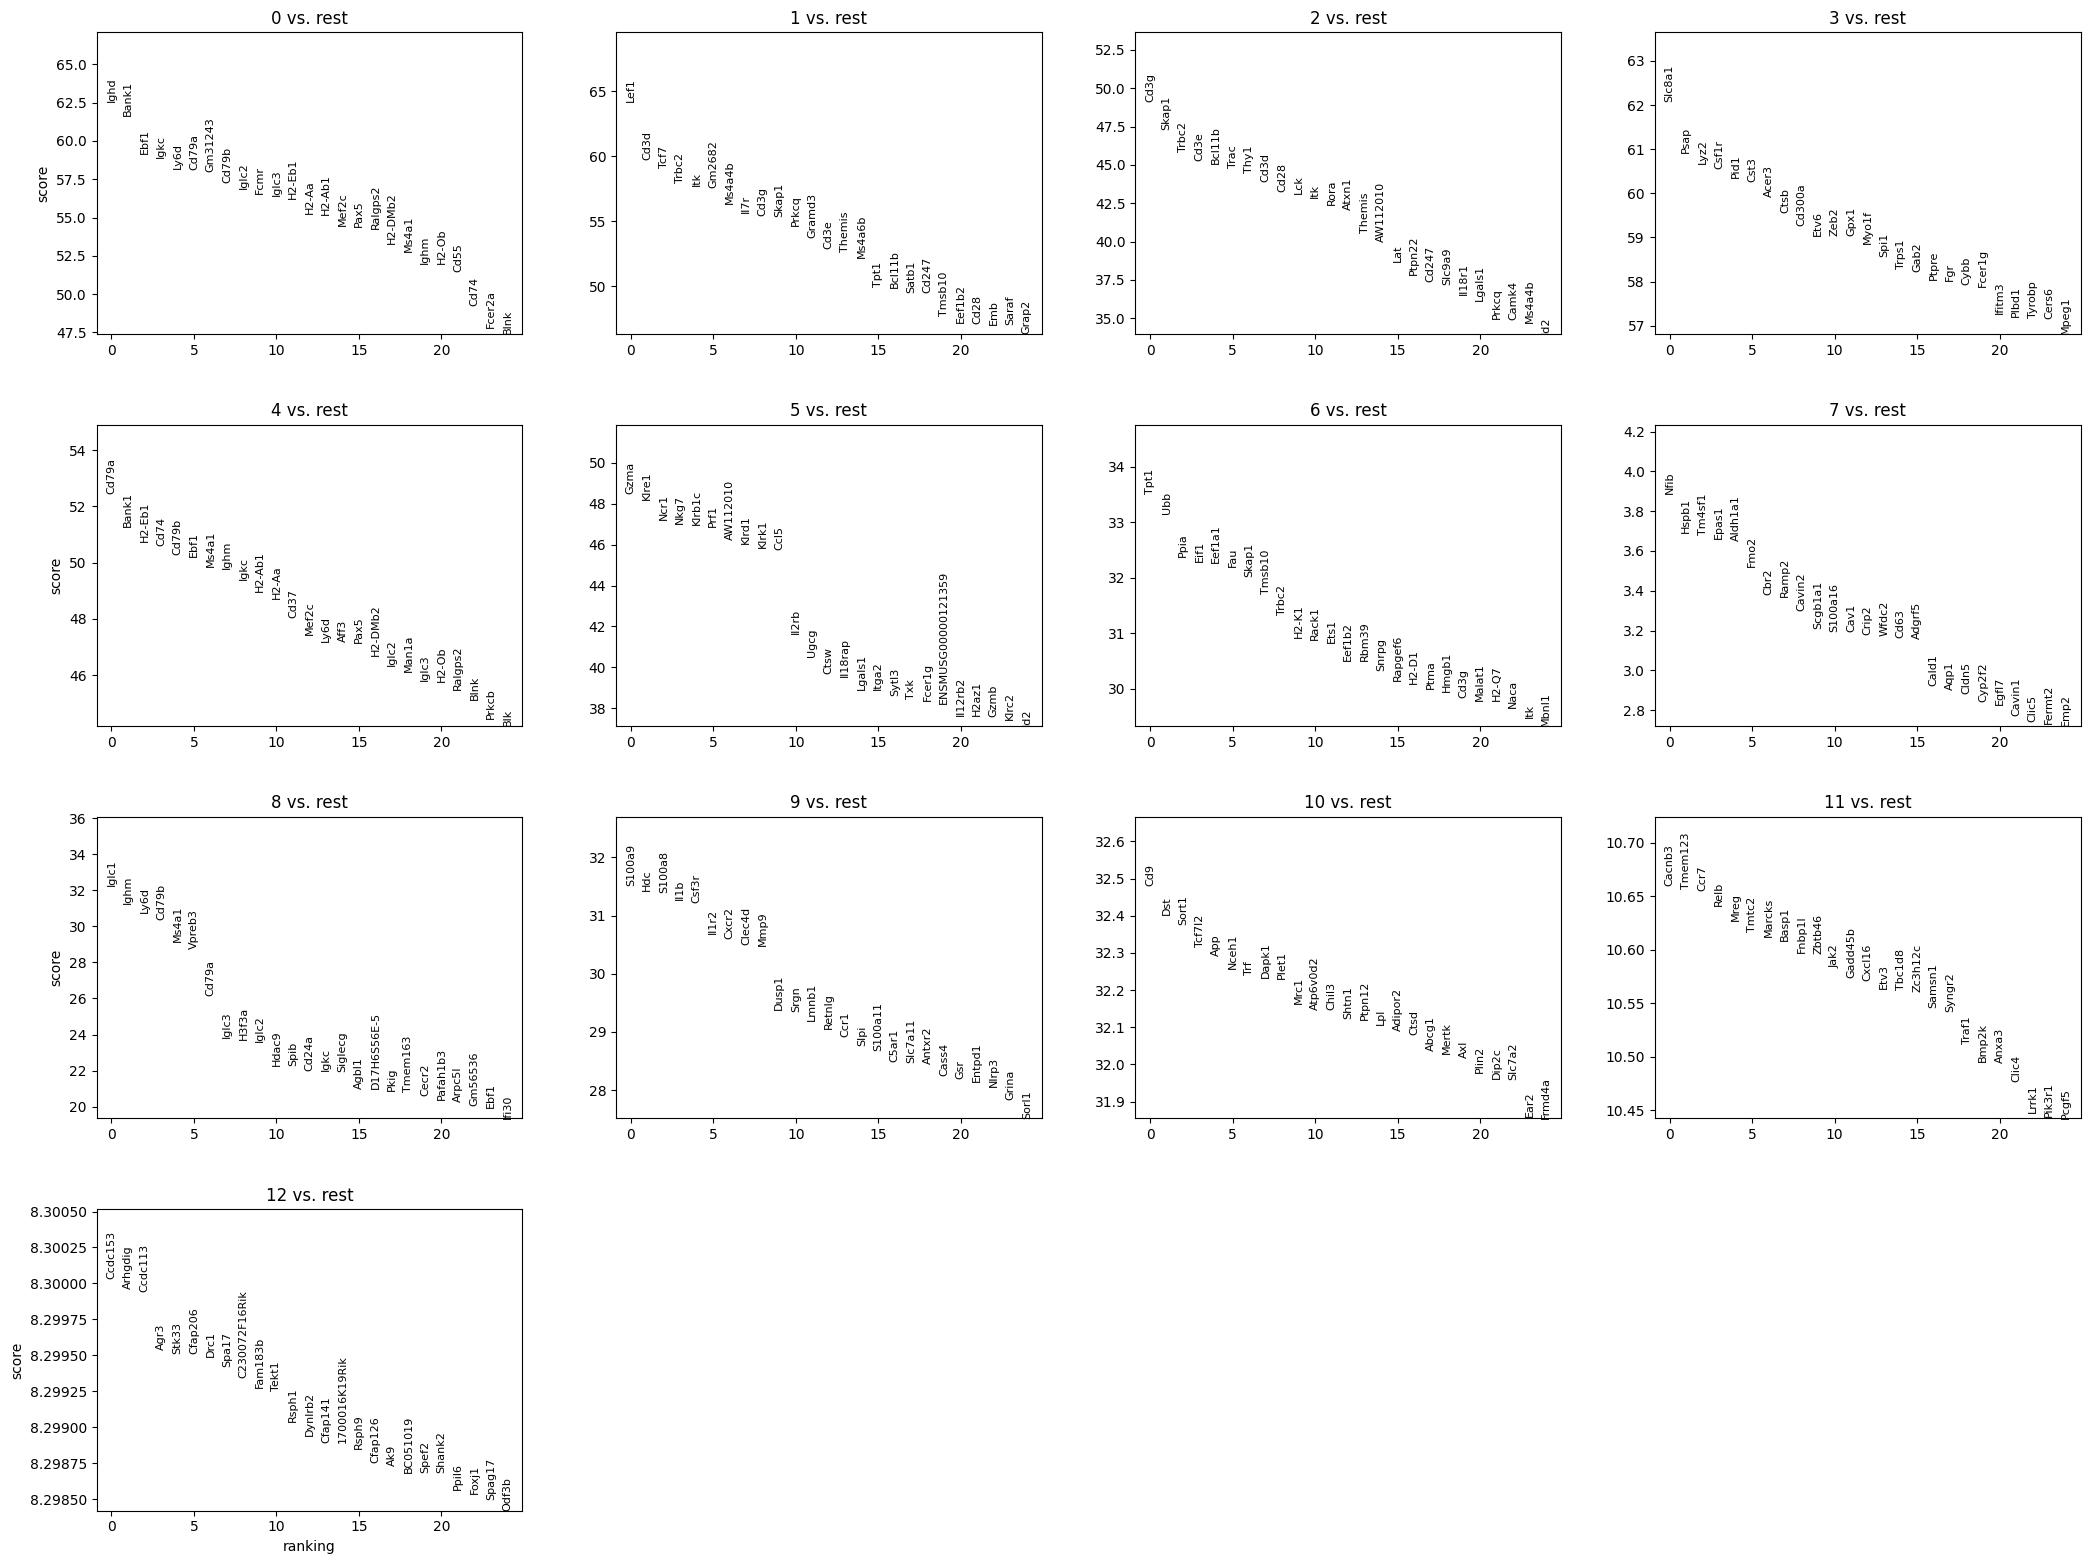

In [40]:
# Differential Expression
sc.tl.rank_genes_groups(merged, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(merged, n_genes=25, sharey=False)


AnnData object with n_obs × n_vars = 15240 × 23213
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


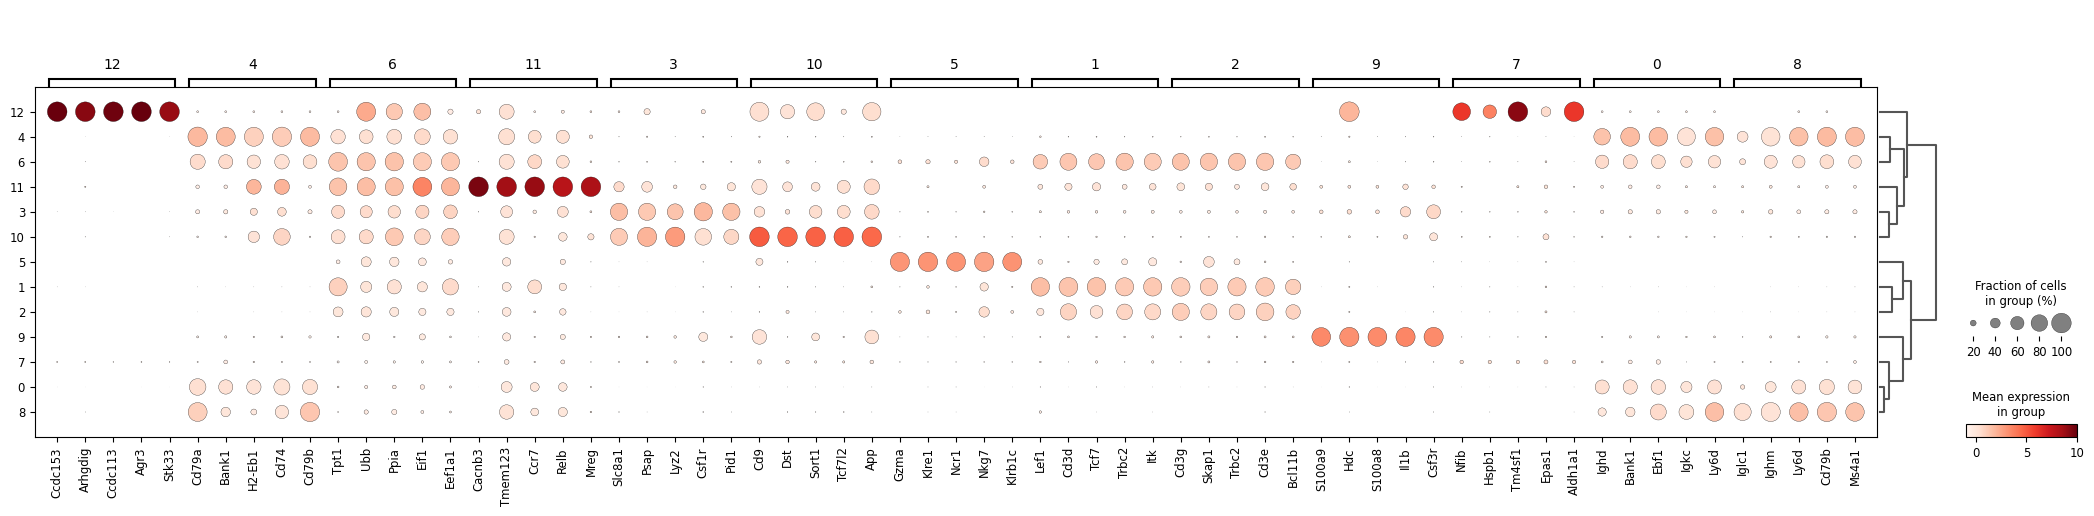

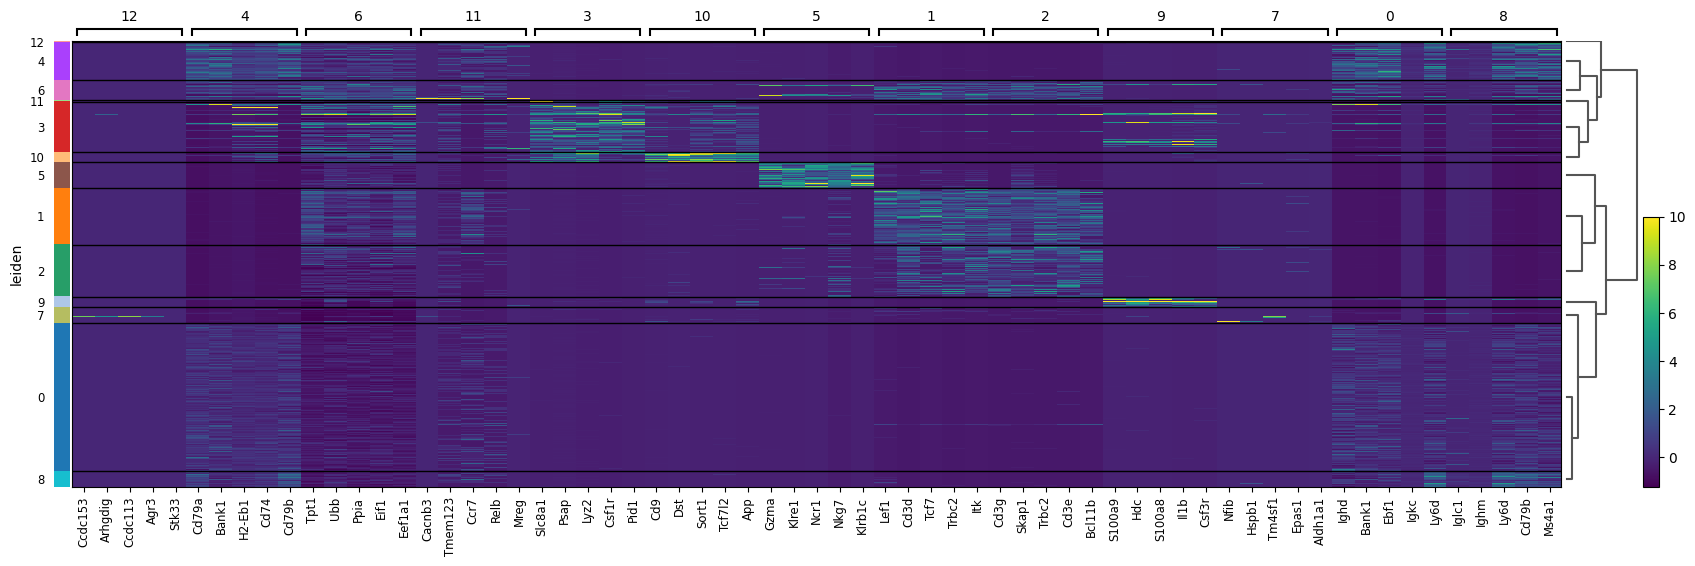

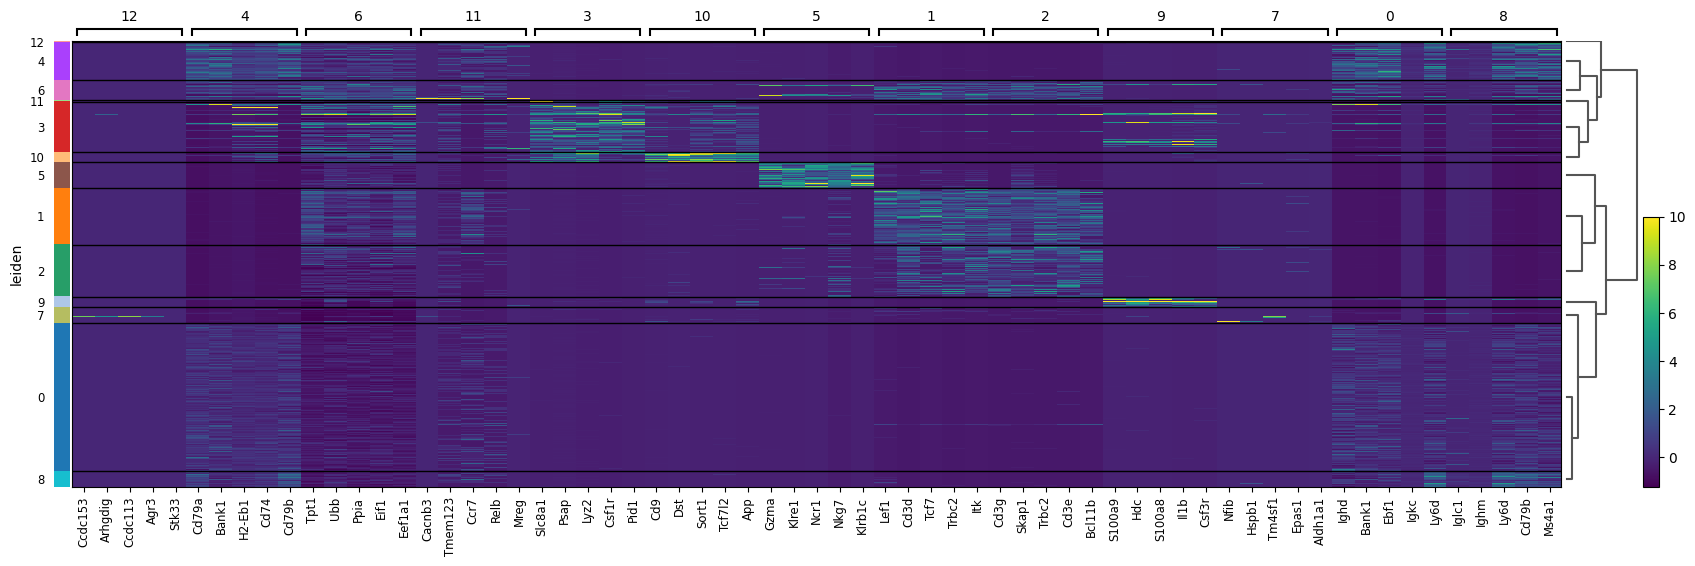

AttributeError: 'NoneType' object has no attribute 'set_title'

In [51]:

# Visualize Data by cluster
sc.tl.dendrogram(merged, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(merged, n_genes=5, groupby='leiden')
sc.pl.rank_genes_groups_heatmap(merged, n_genes=5, groupby='leiden',show_gene_labels=True)



leiden
0     5055
1     1928
2     1782
3     1716
4     1308
5      877
6      696
7      543
8      540
9      369
10     365
11      38
12      23
Name: count, dtype: int64
category
['1', '2', '0', '7', '4', ..., '10', '5', '6', '12', '11']
Length: 13
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']
Cluster '9' exists.
AnnData object with n_obs × n_vars = 369 × 23213
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_col

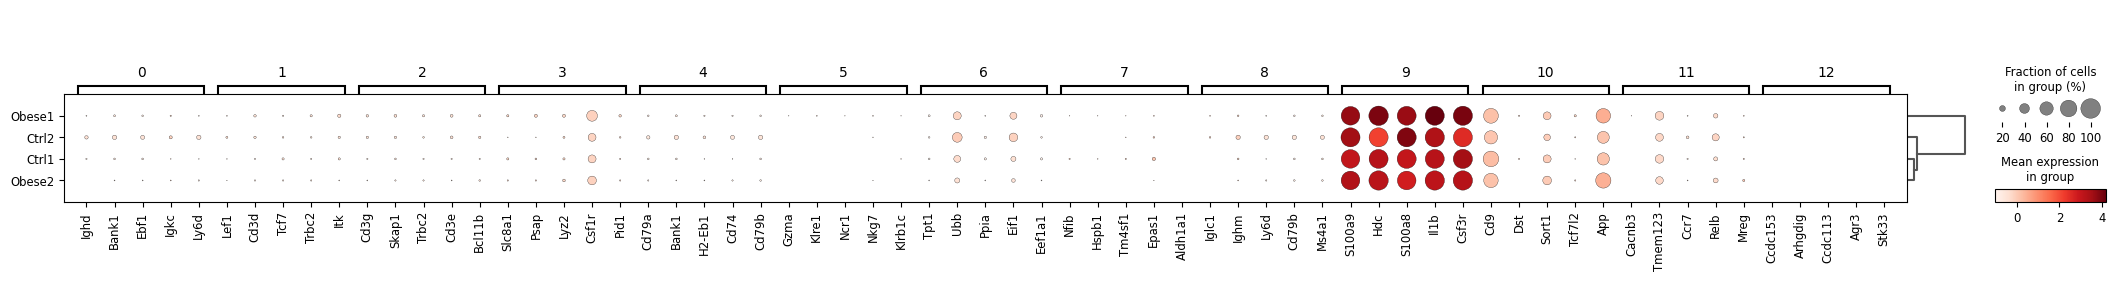

categories: Ctrl1, Ctrl2, Obese1, etc.
var_group_labels: 0, 1, 2, etc.


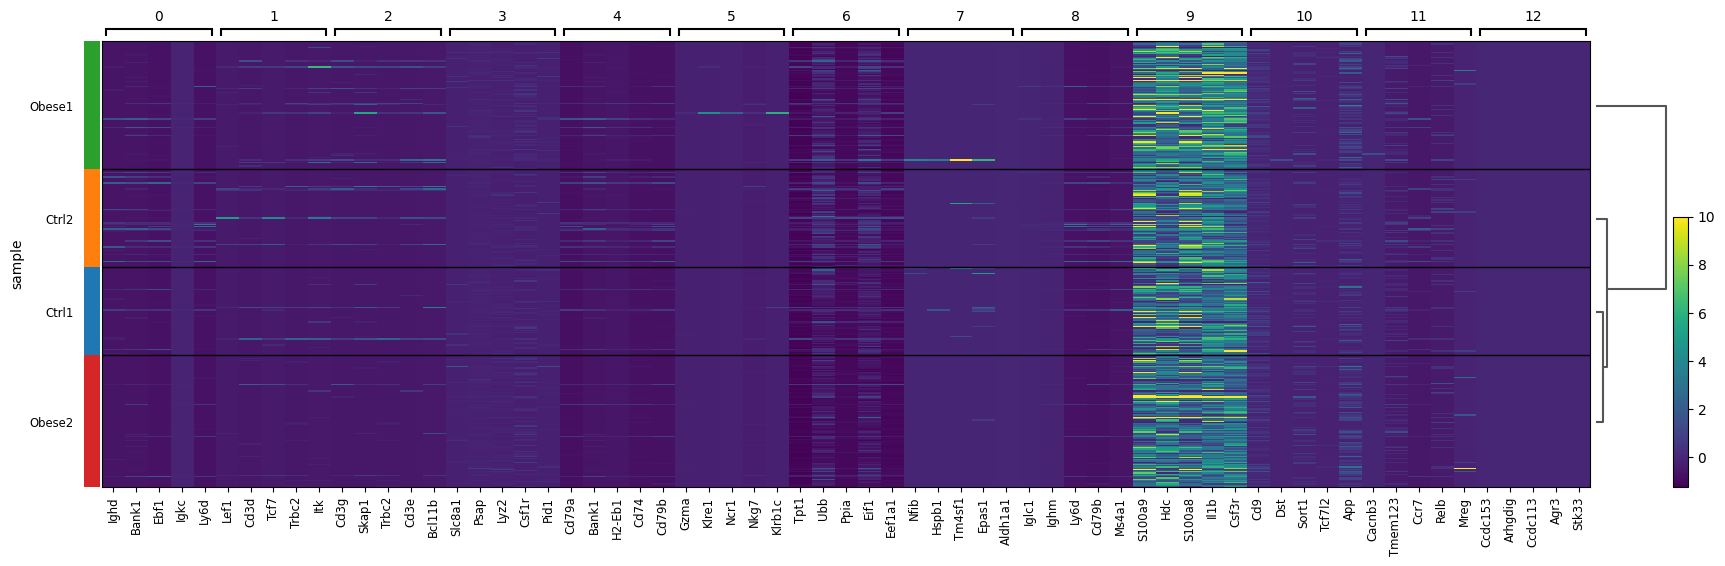

In [59]:
# I was trying something else here to subset the neutrophils but did not end up finishing it

merged_neu = merged[merged.obs['leiden'] == '9'].copy()

sc.pp.scale(merged, max_value=10)
sc.tl.pca(merged, svd_solver='arpack')
sc.pp.neighbors(merged, n_neighbors=10, n_pcs=40)
sc.tl.umap(merged)
sc.tl.leiden(merged, resolution=0.2)

sc.tl.rank_genes_groups(merged_neu, 'sample', method='wilcoxon')
sc.pl.rank_genes_groups(merged_neu, n_genes=25, sharey=False)

sc.tl.dendrogram(merged_neu, groupby='sample')

sc.pl.rank_genes_groups_dotplot(merged_neu, n_genes=5, groupby='sample')

sc.pl.rank_genes_groups_heatmap(merged_neu, n_genes=5, groupby='sample',show_gene_labels=True)


In [20]:
# Store the results of the Differential Expression

# Extract the DE results into a DataFrame
de_results = pd.DataFrame(
    {group: merged.uns['rank_genes_groups']['names'][group] for group in merged.uns['rank_genes_groups']['names'].dtype.names}
)

output_dir = "/Users/25advaym/genomics"
# Save the results to a CSV file for further analysis or reporting
de_results.to_csv(os.path.join(output_dir, 'differential_expression_results.csv'))


Note: you may need to restart the kernel to use updated packages.
